# Using Deep Learning for Sentence Score Prediction - Bi Directional GRUs
## Overview

Sentence-to-sentence GRU for text regression

#### Approach
- Split this data set into two sets - one for training our DL model, and one for evaluation  
- Use Keras to create GRU with multiple layers. We will train this model on both CPU environments  
- Evaluate and test the model on the test set and look at a few individual examples


In [1]:
import numpy as np
import pandas as pd
import os, re, time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from multiprocessing import cpu_count
print(cpu_count())

16


In [2]:
# %pip install pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Available CPUs: 16
INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Convolution1D, Flatten, LeakyReLU
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import SpatialDropout1D, MaxPooling1D, Bidirectional, GRU, concatenate, BatchNormalization
from tensorflow.keras.models import Model, Sequential

2023-05-22 00:10:29.243623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 00:10:33.982321: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-22 00:10:33.982501: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [4]:
tf.config.list_physical_devices()

2023-05-22 00:10:37.349857: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-22 00:10:37.349900: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-22 00:10:37.349935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ml-essay-grading): /proc/driver/nvidia/version does not exist


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
df_proc=pd.read_csv('../00_gcp_data/preprocessed-essay.csv')
# df_proc.head()

In [6]:
pd.options.display.max_colwidth=None
df_proc[['corrected_text','lemmatized_text']].sample(2)

,corrected_text,lemmatized_text
1510,according text think good idea students graduate high school three years graduate high school early going get lot opportunities successful life also think someone decide start working contraction hard works like early three years later person going get lot experience money decide college like graduate college going young ready life lot people became millinery must time spend something experience going get got experience know want life going better easier future people also think bad idea graduate high school three years said early going smart enough successful life said wrong still summer school take extra classes summer school smart need pass classes fail class fail one need take summer school going problem want graduate early also take classes online going busy ready next level know someone dominican republic leaves genericcity went one barbershop ask successful told years old graduate high school ask graduate early told take classes summer school take classes online said good keep telling became successful told graduate went college take classes barbershop years later years old work one year want open busyness open three barbershops genericcity said put best effort thing life going get better everything another thing everybody make hard tip type people never give best put hurt put best effort mon dad going pay food going man house everybody need work hard everyday one successful life conclusion best thing student graduate early must experience get something must money going make life perseverance progress successful got nothing nobody going respect need help people make people fail sometime life easy people got opportunity good life take opportunity,accord text think good idea student graduate high school three year graduate high school early go get lot opportunity successful life also think someone decide start work contraction hard work like early three year later person go get lot experience money decide college like graduate college go young ready life lot people become millinery must time spend something experience go get get experience know want life go well easy future people also think bad idea graduate high school three year say early go smart enough successful life say wrong still summer school take extra class summer school smart need pas class fail class fail one need take summer school go problem want graduate early also take class online go busy ready next level know someone dominican republic leaf genericcity go one barbershop ask successful told year old graduate high school ask graduate early told take class summer school take class online say good keep tell become successful told graduate go college take class barbershop year later year old work one year want open busyness open three barbershop genericcity say put best effort thing life go get well everything another thing everybody make hard tip type people never give best put hurt put best effort mon dad go pay food go man house everybody need work hard everyday one successful life conclusion best thing student graduate early must experience get something must money go make life perseverance progress successful get nothing nobody go respect need help people make people fail sometime life easy people get opportunity good life take opportunity
2220,manager would like work envy nail nail salon salon always want work feel comfortable think someone needs work important person always wanted person like way worker going really good job also sociable friendly think something important customers need feel comfortable way costumer going like job worker likely going back later get done nails salon one year getting nails done salon like techniques workers use time care put make nails think salon perfect people get nails want different color nails salon lot choices color gel acrylic powder would happy lorn techniques styles workers customers like french nail sculpture nail gel nail two years practice basic steps make nail example 

### Setting variables

In [7]:
## Setting text and target variables

textVar=df_proc['lemmatized_text']
targetVar=df_proc[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]]

### Parameters - for GRU

In [24]:
# make our experiments repeatable
np.random.seed(0)

# Model Hyperparameters
embedding_dim = 100

# Here we specify the number of units of our GRU layer
gru_dims = 64

# Training parameters. Here we specify the training of the net will use N examples for each backprop iteration
batch_size = 64

# We will go thru the entire data set N times
num_epochs = 30

# Prepossessing parameters
# We will input the first 1000 words of every essay (and pad out with nulls if a essay review is <1000 words
# We will also build our model using the most frequent 7000 words in our essay 'dictionary'
sequence_length = 1000
max_features = 7000

#Specify the number of classes to predict
num_classes = 6

### Tokenize the data and pad sequences

In [9]:
X = textVar.values
Y = targetVar

train_samples, test_samples, train_targets, test_targets = train_test_split(X,Y, test_size = 0.20, random_state = 1010)

In [10]:
# Check how many columns we have, make sure we have our sequence length set correctly

print(train_samples.shape,train_targets.shape)
print(test_samples.shape,test_targets.shape)

(3128,) (3128, 6)
(783,) (783, 6)


In [11]:
# A TextVectorization layer is created with the specified parameters
vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=sequence_length, ngrams=None, pad_to_max_tokens=True)

# The train_samples tensor is converted into a TensorFlow Dataset 
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)

# The TextVectorization layer is adapted to the dataset text_ds. 
# This process analyzes the text data in text_ds and builds the vocabulary of the vectorizer based on the observed tokens.
vectorizer.adapt(text_ds)

2023-05-22 00:10:37.836382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
vectorizer.get_vocabulary()[:20]

['',
 '[UNK]',
 'student',
 'people',
 'school',
 'work',
 'get',
 'make',
 'time',
 'want',
 'good',
 'help',
 'like',
 'life',
 'thing',
 'would',
 'think',
 'class',
 'one',
 'well']

In [13]:
vectorizer

### Convert our list of strings data to Numpy arrays of integer indices

In [14]:
X_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
X_test = vectorizer(np.array([[s] for s in test_samples])).numpy()

Y_train = np.array(train_targets)
Y_test = np.array(test_targets)

In [15]:
X_train.shape

(3128, 1000)

In [16]:
Y_train.shape

(3128, 6)

### Load a pretrained vector space model - GLOVE

In [17]:
embeddings_index = {}

glove_dir = '../00_gcp_data/'
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [18]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 6638 words (362 misses)


In [19]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.79618001,  0.56779999, -0.96452999, ..., -0.28637001,
         0.54822999, -0.33597001],
       ...,
       [-0.01211   ,  0.001921  , -0.26157999, ...,  0.039627  ,
        -0.12142   , -0.44775   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Load the pre-trained word embeddings matrix into an Embedding layer
We will keep embeddings static with **trainable=False**

In [152]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

### Adding our loss function

In [21]:
## Adding a custom loss function

def mcrmse(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=0)

## GRU Model based on Glove word embeddings  

### Create GRU Neural Network Structure

Bidirectional GRUs / LSTMs train two instead of one GRUs / LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This provides additional context to the network and result in faster and fuller learning of the sentense / language model.

The goal is to predict one value per timestep given the full sequence provided as input. This requires that the GRUs / LSTMs hidden layer returns a sequence of values (one per timestep) rather than a single value for the whole input sequence (return_sequences=True)

## Baseline GRU Model

In [154]:
inputs = Input(shape=(sequence_length, ))

x = Embedding(num_tokens, embedding_dim, weights=[embedding_matrix])(inputs)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(gru_dims, return_sequences=True))(x)
flatten_1 = Flatten()(concate_1)

# Create a concatenation of GlobalAveragePooling1D and GlobalMaxPooling1D layers
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
concatenated = concatenate([avg_pool, max_pool])
x = Dense(128, activation = 'relu')(concatenated)
x = BatchNormalization()(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(32, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(16, activation = 'relu')(x)
x = BatchNormalization()(x)
outputs = Dense(6, activation = 'linear')(x)

model_gru_1 = Model(inputs=inputs, outputs=outputs)
model_gru_1.compile(loss = mcrmse, optimizer='adam', metrics = mcrmse)

print(model_gru_1.summary())

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1000)]       0           []                               
                                                                                                  
 embedding_19 (Embedding)       (None, 1000, 100)    700200      ['input_15[0][0]']               
                                                                                                  
 spatial_dropout1d_15 (SpatialD  (None, 1000, 100)   0           ['embedding_19[0][0]']           
 ropout1D)                                                                                        
                                                                                                  
 bidirectional_15 (Bidirectiona  (None, 1000, 128)   63744       ['spatial_dropout1d_15[0][

## Training the model

In [155]:
from tensorflow.keras.callbacks import *
import os
reduce_lr = ReduceLROnPlateau(monitor = 'val_mcrmse', factor = 0.25, patience = 2, verbose = 1)
earlystop = EarlyStopping(monitor = 'val_mcrmse',  mode="min", min_delta = 0, patience = 25,verbose = 1)

filepath="/home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_squared_error',
                             verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='min')

#only save model if it reduces MSE
callbacks = [reduce_lr,earlystop,checkpoint]

t1 = time.time()
model_gru_1_history = model_gru_1.fit(X_train, Y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_split=0.2,
                    callbacks = callbacks,
                    verbose=1)
t2 = time.time()
print("GRU Glove model train time = %d seconds" %(t2-t1))

Epoch 1/15
25/25 [==============================] - ETA: 0s - loss: 3.2566 - mcrmse: 3.2544WARNING:tensorflow:Can save best model only with val_mean_squared_error available, skipping.


25/25 [==============================] - 32s 1s/step - loss: 3.2566 - mcrmse: 3.2544 - val_loss: 3.0902 - val_mcrmse: 3.0895 - lr: 0.0010
Epoch 2/15
25/25 [==============================] - ETA: 0s - loss: 3.1029 - mcrmse: 3.1050WARNING:tensorflow:Can save best model only with val_mean_squared_error available, skipping.


25/25 [==============================] - 21s 849ms/step - loss: 3.1029 - mcrmse: 3.1050 - val_loss: 2.9994 - val_mcrmse: 2.9987 - lr: 0.0010
Epoch 3/15
25/25 [==============================] - ETA: 0s - loss: 3.0004 - mcrmse: 3.0026WARNING:tensorflow:Can save best model only with val_mean_squared_error available, skipping.


25/25 [==============================] - 18s 721ms/step - loss: 3.0004 - mcrmse: 3.0026 - val_loss: 2.8424 - val_mcrmse: 2.8418 - lr: 0.0010
Epoch 4/15
25/25 [==============================] - ETA: 0s - loss: 2.8784 - mcrmse: 2.8749WARNING:tensorflow:Can save best model only with val_mean_squared_error available, skipping.


25/25 [==============================] - 24s 968ms/step - loss: 2.8784 - mcrmse: 2.8749 - val_loss: 2.6722 - val_mcrmse: 2.6716 - lr: 0.0010
Epoch 5/15
25/25 [==============================] - ETA: 0s - loss: 2.7213 - mcrmse: 2.7168WARNING:tensorflow:Can save best model only with val_mean_squared_error available, skipping.


25/25 [==============================] - 24s 989ms/step - loss: 2.7213 - mcrmse: 2.7168 - val_loss: 2.4869 - val_mcrmse: 2.4863 - lr: 0.0010
Epoch 6/15
25/25 [==============================] - ETA: 0s - loss: 2.5178 - mcrmse: 2.5169WARNING:tensorflow:Can save best model only with val_mean_squared_error available, skipping.


25/25 [==============================] - 21s 850ms/step - loss: 2.5178 - mcrmse: 2.5169 - val_loss: 2.2818 - val_mcrmse: 2.2811 - lr: 0.0010
Epoch 7/15
25/25 [==============================] - ETA: 0s - loss: 2.2679 - mcrmse: 2.2658WARNING:tensorflow:Can save best model only with val_mean_squared_error available, skipping.


25/25 [==============================] - 18s 711ms/step - loss: 2.2679 - mcrmse: 2.2658 - val_loss: 1.9559 - val_mcrmse: 1.9555 - lr: 0.0010
Epoch 8/15
25/25 [==============================] - ETA: 0s - loss: 1.9673 - mcrmse: 1.9633WARNING:tensorflow:Can save best model only with val_mean_squared_error available, skipping.


25/25 [==============================] - 24s 980ms/step - loss: 1.9673 - mcrmse: 1.9633 - val_loss: 1.8636 - val_mcrmse: 1.8628 - lr: 0.0010
Epoch 9/15
25/25 [==============================] - ETA: 0s - loss: 1.6191 - mcrmse: 1.6131WARNING:tensorflow:Can save best model only with val_mean_squared_error available, skipping.


25/25 [==============================] - 24s 984ms/step - loss: 1.6191 - mcrmse: 1.6131 - val_loss: 1.3141 - val_mcrmse: 1.3136 - lr: 0.0010
Epoch 10/15
25/25 [==============================] - ETA: 0s - loss: 1.2514 - mcrmse: 1.2486WARNING:tensorflow:Can save best model only with val_mean_squared_error available, skipping.


25/25 [==============================] - 21s 858ms/step - loss: 1.2514 - mcrmse: 1.2486 - val_loss: 0.9458 - val_mcrmse: 0.9453 - lr: 0.0010
Epoch 11/15
25/25 [==============================] - ETA: 0s - loss: 0.8944 - mcrmse: 0.8914WARNING:tensorflow:Can save best model only with val_mean_squared_error available, skipping.


25/25 [==============================] - 18s 727ms/step - loss: 0.8944 - mcrmse: 0.8914 - val_loss: 0.9453 - val_mcrmse: 0.9435 - lr: 0.0010
Epoch 12/15
25/25 [==============================] - ETA: 0s - loss: 0.6799 - mcrmse: 0.6792WARNING:tensorflow:Can save best model only with val_mean_squared_error available, skipping.


25/25 [==============================] - 24s 962ms/step - loss: 0.6799 - mcrmse: 0.6792 - val_loss: 0.6444 - val_mcrmse: 0.6433 - lr: 0.0010
Epoch 13/15
25/25 [==============================] - ETA: 0s - loss: 0.5850 - mcrmse: 0.5864WARNING:tensorflow:Can save best model only with val_mean_squared_error available, skipping.


25/25 [==============================] - 24s 955ms/step - loss: 0.5850 - mcrmse: 0.5864 - val_loss: 0.9103 - val_mcrmse: 0.9076 - lr: 0.0010
Epoch 14/15
25/25 [==============================] - ETA: 0s - loss: 0.5484 - mcrmse: 0.5499
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


25/25 [==============================] - 21s 841ms/step - loss: 0.5484 - mcrmse: 0.5499 - val_loss: 0.6525 - val_mcrmse: 0.6512 - lr: 0.0010
Epoch 15/15
25/25 [==============================] - ETA: 0s - loss: 0.5173 - mcrmse: 0.5166WARNING:tensorflow:Can save best model only with val_mean_squared_error available, skipping.


25/25 [==============================] - 19s 767ms/step - loss: 0.5173 - mcrmse: 0.5166 - val_loss: 0.5910 - val_mcrmse: 0.5907 - lr: 2.5000e-04
GRU Glove model train time = 333 seconds


In [156]:
model_gru_1_history.history.keys()

dict_keys(['loss', 'mcrmse', 'val_loss', 'val_mcrmse', 'lr'])

In [27]:
def plot_train_rmse(history):
    """
    Plot the keras epoch results thru training
    """
    h = history.history
    epochs = range(1, len(h['mcrmse']) + 1)
    plt.subplots(1,1,figsize=(13,8))
    plt.plot(epochs, h['mcrmse'], 'r', label='Training RMSE')
    plt.plot(epochs, h['val_mcrmse'], 'g', label='Validation RMSE')
    plt.title('Training and Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

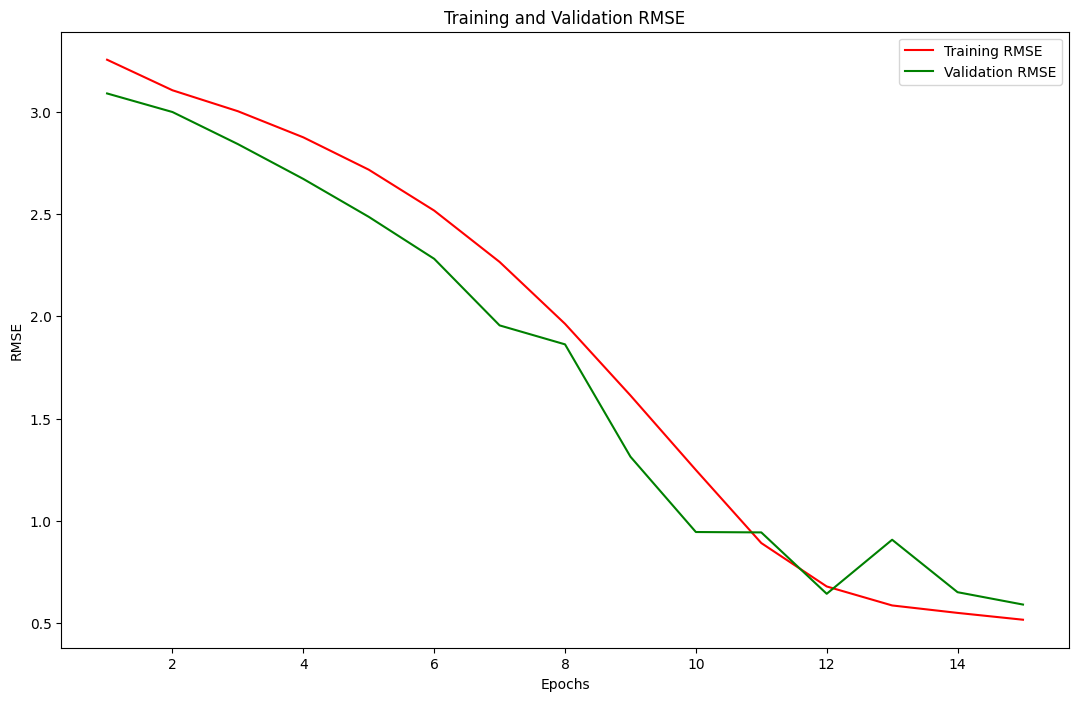

In [158]:
plot_train_rmse(model_gru_1_history)

In [160]:
model_gru_1.evaluate(X_test, Y_test)

25/25 [==============================] - 4s 179ms/step - loss: 0.5978 - mcrmse: 0.5958


[0.5978489518165588, 0.5958216190338135]

### GRU Model 2

In [23]:
inputs = Input(shape=(sequence_length, ))

x = Embedding(num_tokens, embedding_dim, weights=[embedding_matrix])(inputs)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(gru_dims, return_sequences=True))(x)
x = Flatten()(x)

# Create a concatenation of GlobalAveragePooling1D and GlobalMaxPooling1D layers
# avg_pool = GlobalAveragePooling1D()(x)
# max_pool = GlobalMaxPooling1D()(x)
# concatenated = concatenate([avg_pool, max_pool])
x = Dense(128, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(32, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(16, activation = 'relu')(x)
x = BatchNormalization()(x)
outputs = Dense(6, activation = 'linear')(x)

model_gru_2 = Model(inputs=inputs, outputs=outputs)
model_gru_2.compile(loss = mcrmse, optimizer='adam', metrics = mcrmse)

print(model_gru_2.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_2 (Embedding)     (None, 1000, 100)         700200    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 1000, 100)        0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 1000, 128)        63744     
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 128000)            0         
                                                                 
 dense_10 (Dense)            (None, 128)               1638

In [25]:
from tensorflow.keras.callbacks import *
import os
reduce_lr = ReduceLROnPlateau(monitor = 'val_mcrmse', factor = 0.25, patience = 2, verbose = 1)
earlystop = EarlyStopping(monitor = 'val_mcrmse',  mode="min", min_delta = 0, patience = 25,verbose = 1)

filepath="/home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_2"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_squared_error',
                             verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='min')

#only save model if it reduces MSE
callbacks = [reduce_lr,earlystop,checkpoint]

t1 = time.time()
model_gru_2_history = model_gru_2.fit(X_train, Y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_split=0.2,
                    callbacks = callbacks,
                    verbose=1)
t2 = time.time()
print("GRU Glove model train time = %d seconds" %(t2-t1))

Epoch 1/30
40/40 [==============================] - 37s 803ms/step - loss: 3.1797 - mcrmse: 3.1688 - val_loss: 2.6814 - val_mcrmse: 2.6801 - lr: 0.0010
Epoch 2/30
40/40 [==============================] - 35s 871ms/step - loss: 3.0113 - mcrmse: 3.0039 - val_loss: 2.6151 - val_mcrmse: 2.6159 - lr: 0.0010
Epoch 3/30
40/40 [==============================] - 30s 736ms/step - loss: 2.8218 - mcrmse: 2.8182 - val_loss: 2.6055 - val_mcrmse: 2.6067 - lr: 0.0010
Epoch 4/30
40/40 [==============================] - 31s 784ms/step - loss: 2.5200 - mcrmse: 2.5178 - val_loss: 2.2531 - val_mcrmse: 2.2544 - lr: 0.0010
Epoch 5/30
40/40 [==============================] - 34s 863ms/step - loss: 2.0877 - mcrmse: 2.0801 - val_loss: 1.9845 - val_mcrmse: 1.9852 - lr: 0.0010
Epoch 6/30
40/40 [==============================] - 33s 836ms/step - loss: 1.5480 - mcrmse: 1.5393 - val_loss: 1.1477 - val_mcrmse: 1.1487 - lr: 0.0010
Epoch 7/30
40/40 [==============================] - 36s 899ms/step - loss: 1.0254 - mcrm

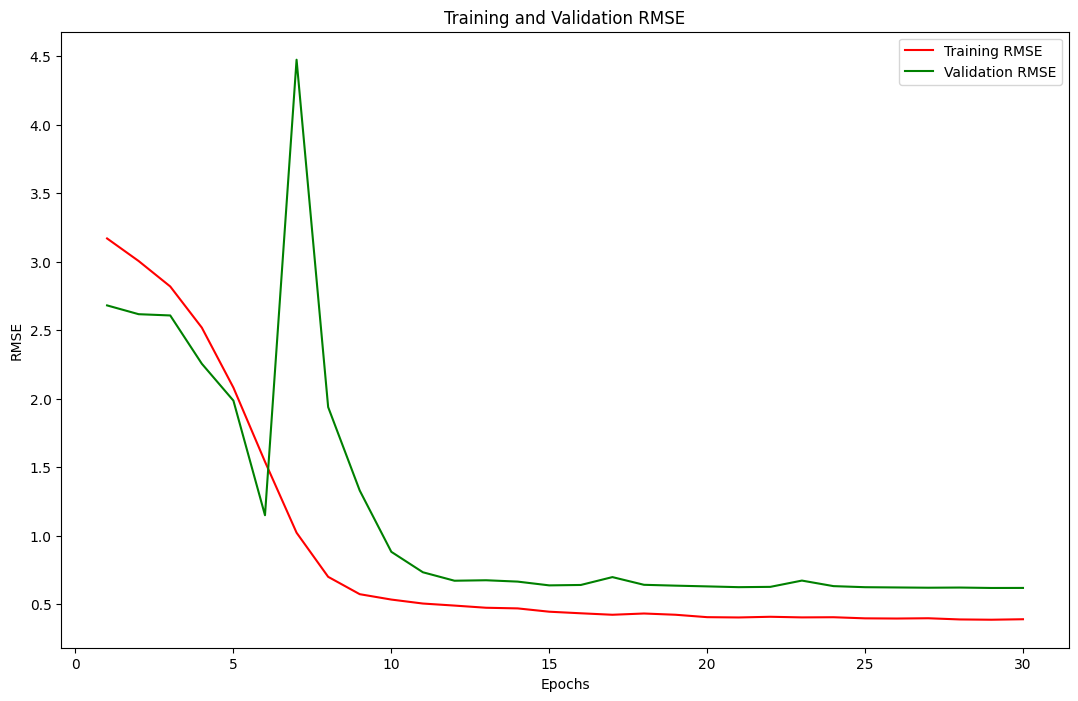

In [28]:
plot_train_rmse(model_gru_2_history)

In [29]:
model_gru_2.evaluate(X_test, Y_test)

25/25 [==============================] - 5s 203ms/step - loss: 0.6299 - mcrmse: 0.6277


[0.6299134492874146, 0.627717912197113]

In [30]:
model_gru_2.save('model_gru_2.h5')

In [32]:
def save_epochs(history):
    h = history.history
    df = pd.DataFrame({'Epochs':list(range(1, len(h['mcrmse']) + 1)), 'RMSE':list(h['mcrmse'])})
    return df

In [33]:
model_gru_2_epochs_df=save_epochs(model_gru_2_history)
model_gru_2_epochs_df.to_csv('model_gru_2_epochs_df.csv', index=False)